# Stepik success rate

__Построить модель предсказания сколько студентов закончит курс__

### Author: Стурейко Игорь
### Project: Stepik success rate

## Описание данных

__events_train.csv__ - данные о действиях, которые совершают студенты со стэпами

* step_id - id стэпа
* user_id - анонимизированный id юзера
* timestamp - время наступления события в формате unix date
* action - событие, возможные значения: 
    * discovered - пользователь перешел на стэп
    * viewed - просмотр шага,
    * started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    * passed - удачное решение практического шага


__submissions_train.csv__ - данные о времени и статусах сабмитов к практическим заданиям

* step_id - id стэпа
* timestamp - время отправки решения в формате unix date
* submission_status - статус решения
* user_id - анонимизированный id юзера

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
events_data = pd.read_csv('event_data_train.csv')

In [3]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


Посмотрим уникальные события

In [4]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Соответствует описанию данных - уже хорошо

 Преобразуем время-дату к читаемому формату

In [5]:
events_data['data'] = pd.to_datetime(events_data['timestamp'], unit='s')

In [6]:
events_data.head(5)

,step_id,timestamp,action,user_id,data
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [7]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
data         datetime64[ns]
dtype: object

In [8]:
events_data['day'] = events_data.data.dt.date

In [9]:
events_data.head(5)

,step_id,timestamp,action,user_id,data,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Посмотрим распределение притока новых пользователей по времени

<AxesSubplot:xlabel='day'>

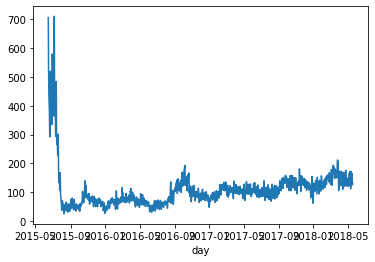

In [10]:
events_data.groupby('day')\
    .user_id.nunique().plot()

Работать с выбросами можно с помощью реализации одноклассовой машины опорных векторов (One-class Support Vector Machine) в библиотеке Scikit-learn

https://habr.com/ru/post/251225/

Сколько баллов суммарно набрали пользователи за курс

In [25]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', 
                        aggfunc='count', fill_value=0).reset_index()\
                        .head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Распределение пользователей по количесту набраных баллов

<AxesSubplot:>

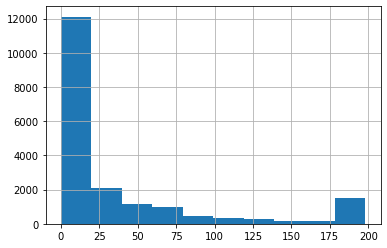

In [81]:
users_events_date = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_events_date['discovered'].hist()

Считаем данные из submission

In [31]:
submission_data = pd.read_csv('submissions_data_train.csv')
submission_data['data'] = pd.to_datetime(submission_data['timestamp'], unit='s')
submission_data['day'] = submission_data.data.dt.date
submission_data.head(2)

,step_id,timestamp,submission_status,user_id,data,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15


In [34]:
users_scores = submission_data.pivot_table(index='user_id', 
                                           columns='submission_status',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [38]:
submission_data['user_id'].nunique()

9940

In [39]:
events_data['user_id'].nunique()

19234

После какого времени отсутствия пользователя мы будем его считать потерянным?

Только 10% пользователей возвращаются на курс имея перерыв более 18 дней


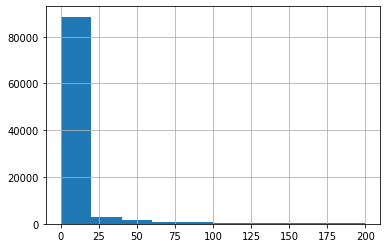

In [54]:
gap_date = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

gap_date = pd.Series(np.concatenate(gap_date, axis=0))
gap_date = gap_date / (24 * 60 * 60)
gap_date[gap_date < 200].hist()
print(f'Только 10% пользователей возвращаются на курс имея перерыв более \
{int(gap_date.quantile(0.90))} дней')

In [56]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [58]:
users_scores.sort_values(by='correct', ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2


In [77]:
users_date = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [78]:
now = events_data['timestamp'].max()
drop_threshold = 30*24*60*60 # количество секунд в месяце

In [79]:
users_date['is_gone_user'] = (now - users_date['last_timestamp']) > drop_threshold
users_date.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Соберем таблицу с подготовленными данными

Смержим со скорами (__не забываем - outer join__)

In [80]:
users_date = users_date.merge(users_scores, on='user_id', how='outer')
users_date = users_date.fillna(0)
users_date.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


Смержим с событиями прохождения курса

In [83]:
users_date = users_date.merge(users_events_date, on='user_id', how='outer')
users_date = users_date.fillna(0)
users_date.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Смержим количество дней проведенных на курсе

In [86]:
users_days = events_data.groupby('user_id')['day'].nunique()
users_days = users_days.to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [87]:
users_date = users_date.merge(users_days, on='user_id', how='outer')
users_date = users_date.fillna(0)
users_date.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Проверяем не потеряли ли мы данные

In [90]:
users_date.user_id.nunique() == events_data.user_id.nunique()

True

Все данные на месте. Пользователи не потеряны

Прошел ли юзер курс?

In [92]:
passed_score = 170 # волевое решение что проходной балл равен 170

In [93]:
users_date['passed_course'] = users_date.passed > passed_score

In [94]:
users_date.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


А сколько юзеров прошло курс?

In [97]:
users_date.groupby('passed_course').count()[['user_id']]

,user_id
passed_course,
False,17809
True,1425


In [106]:
passed = users_date.groupby('passed_course').count()[['user_id']].reset_index()['user_id']

In [113]:
print(f'Прошло курс {int(100* passed[1]/passed[0])}% пользователей')

Прошло курс 8% пользователей
